In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

device = 'cuda:2'

In [2]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
# ImageNet

# data_path="/root/data/ILSVRC2012_val/"

# _, valid_datasets = get_datasets("imagenet1k", data_path)
# valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)

# model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# eval_mode = model.eval()

# # n02443484: 40 black-footed_ferret
# # n01614925: 398 bald_eagle

# data_path="/root/data/ILSVRC2012_val/"

# ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
# ferrot_idx = os.listdir(ferrot_dir)[1]
# ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
# ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# # eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# # eagle_idx = os.listdir(eagle_dir)[1]
# # eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# # eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [3]:
import torchvision
import torchvision.transforms as T

import random
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

CIFAR10_STATS = {
'mean' : [0.4914, 0.4822, 0.4465],
'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])


valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked', train=False, transform=transform)

classifier = torch.load('/data8/donghun/cifar10/results/densenet/script_model.pt', map_location='cpu')
model = classifier.eval().to(device)

attr = np.load('/home/dhlee/results/cifar10/latent_gradient_ascent_attribution.npy')

from ig_pkg.utils.autoencoder_examiner import AutoencoderExaminer

ae = torch.load('/data8/donghun/cifar10/results/ae/script_model.pt', map_location='cpu')
ae.to(device)

/home/dhlee/anaconda3/envs/dh1/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=AutoEncoder
  (img_resize): RecursiveScriptModule(original_name=Resize)
  (encoder): RecursiveScriptModule(
    original_name=EncoderModule
    (encoder): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=LeakyReLU)
      )
      (1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=LeakyReLU)
      )
      (2): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=LeakyReLU

In [26]:
"""
    how to solve
    mask_MoRF - input has been contaminated
    detach().clone()
    
    why this happen?
"""

def aopc(input, label, attr, model, device, ratio, **kwargs):
    # input 3, 224, 224 / attr 224, 224
    input = input.to(device)    
    logit = model.forward(input.unsqueeze(0))    
    score_orig = nn.functional.softmax(logit, dim = -1)    
    prob_orig = score_orig[0, label].item()

    input_hat = mask_MoRF(input, attr, ratio)
    logit_new = model(input_hat.unsqueeze(0))
    score_new = nn.functional.softmax(logit_new, dim =-1)
    prob_new = score_new[0, label].item()
    print(torch.sum(input), torch.sum(input_hat))
    # print(float(torch.sum(x - input_hat)))
    metric_aopc = float(prob_orig - prob_new)  
    # print(metric_aopc)
    return metric_aopc

def mask_MoRF(input, attr, ratio):
    x = input.detach().clone()
    print(1, torch.sum(x))
    original_size = x.size() 
    x = x.reshape(3, -1) 
    attr = torch.tensor(attr).flatten() 
    v, index = torch.sort(attr, descending=True, dim=0)    
    index = index[:int(x.size(1)*ratio)]
#     print(x.size(1)*ratio)
    x[:, index] = 0.0 
    x = x.reshape(*original_size)
    print(2, torch.sum(x))
    return x 

In [27]:
# from ig_pkg.utils.metrics import aopc
sc = 0
for i in range(10):
    ao = aopc(valid_dataset[i][0], valid_dataset[i][1], attr[i], model, device, 0.2)
    # print(ao)
    sc += ao
print(sc)

1 tensor(-738.5452, device='cuda:2')
2 tensor(-627.2239, device='cuda:2')
tensor(-738.5452, device='cuda:2') tensor(-627.2239, device='cuda:2')
1 tensor(2063.6416, device='cuda:2')
2 tensor(1542.6411, device='cuda:2')
tensor(2063.6416, device='cuda:2') tensor(1542.6411, device='cuda:2')
1 tensor(713.0543, device='cuda:2')
2 tensor(224.2526, device='cuda:2')
tensor(713.0543, device='cuda:2') tensor(224.2526, device='cuda:2')
1 tensor(2044.8159, device='cuda:2')
2 tensor(1470.5743, device='cuda:2')
tensor(2044.8159, device='cuda:2') tensor(1470.5743, device='cuda:2')
1 tensor(-797.4079, device='cuda:2')
2 tensor(-501.4545, device='cuda:2')
tensor(-797.4079, device='cuda:2') tensor(-501.4545, device='cuda:2')
1 tensor(-1379.2340, device='cuda:2')
2 tensor(-966.6843, device='cuda:2')
tensor(-1379.2340, device='cuda:2') tensor(-966.6843, device='cuda:2')
1 tensor(-2709.5806, device='cuda:2')
2 tensor(-2233.9570, device='cuda:2')
tensor(-2709.5806, device='cuda:2') tensor(-2233.9570, device=

AE - latent linear

In [8]:
from ig_pkg.utils.autoencoder_examiner import AutoencoderExaminer

ae = torch.load('/data8/donghun/cifar10/results/ae/script_model.pt', map_location='cpu')
ae.to(device)
# print(ae.device)


RecursiveScriptModule(
  original_name=AutoEncoder
  (img_resize): RecursiveScriptModule(original_name=Resize)
  (encoder): RecursiveScriptModule(
    original_name=EncoderModule
    (encoder): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=LeakyReLU)
      )
      (1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=LeakyReLU)
      )
      (2): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=LeakyReLU

In [79]:
interpolation_z = []
interpolation = []
attribution = []
for i in range(10):
    temp = valid_dataset[i][0].to(device)
    j = np.random.randint(10000)    
    base = valid_dataset[j][0].to(device)
    
    x_hat, loss_dict, info1 = AutoencoderExaminer.reconstruct_input(ae, temp.unsqueeze(0))    
    x_hat, loss_dict, info2 = AutoencoderExaminer.reconstruct_input(ae, base.unsqueeze(0))    
    z = info1['bottleneck'] # 1, 512, 2, 2
    # print(z.shape)
    
    z_hat = info2['bottleneck']    

    interp_z = linear_interpolation(z, 10, z_hat) # 11, 1, 512, 2, 2
    interpolation_z.append(interp_z)
    
    # fig, axes = plt.subplots(2, 6)
    # axes_flat = axes.flat 
    # my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))    
    t = []
    for i in range(interp_z.size(0)):
        interp = AutoencoderExaminer.reconstruct_latent(ae, interp_z[i]) # 1, 3, 32, 32
        # print(interp.shape)
        # break
        t.append(interp.squeeze(0))
    # break
    
    
    t = torch.stack(t) # 11, 3, 32, 32
    interpolation.append(t)

    attr = integrated_gradient(model, temp, valid_dataset[i][1], base, t, device)
    attribution.append(attr)
    
interpolation = torch.stack(interpolation)
# interpolation.shape
attribution = torch.stack(attribution)

In [89]:
z = np.load('/home/dhlee/code/ig_inversion/results/cifar10/latent_linear_interpolation_z.npy')
img = np.load('/home/dhlee/code/ig_inversion/results/cifar10/latent_linear_interpolation.npy')
attr = np.load('/home/dhlee/code/ig_inversion/results/cifar10/latent_linear_attribution.npy')

print(z.shape)
print(img.shape)
print(attr.shape)

(12, 11, 1, 512, 2, 2)
(12, 11, 3, 32, 32)
(12, 32, 32)


(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


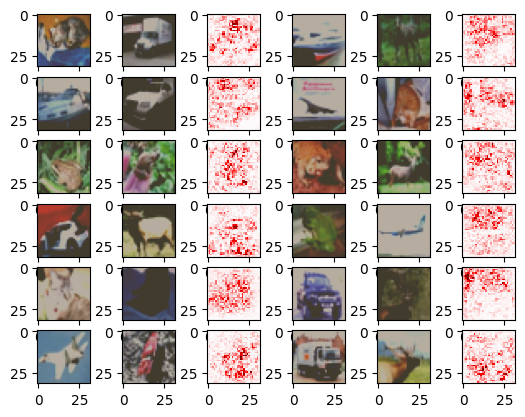

In [91]:
from ig_pkg.misc import convert_to_img, process_heatmap

fig, axes = plt.subplots(6, 6)
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


for i in range(12):    
    
    ax = next(axes_flat)
    temp = torch.from_numpy(img[i][-1])
    ax.imshow(convert_to_img(temp))
    
    ax = next(axes_flat)
    temp = torch.from_numpy(img[i][0])
    ax.imshow(convert_to_img(temp))
    
    ax = next(axes_flat)
    # temp = torch.from_numpy(attr[i])
    # print(temp.shape)
    # print(attr[i].shape)
    attr1, kwargs  = process_heatmap(torch.tensor(attr[i]), my_cmap)
    # ax.imshow(convert_to_img(temp))
    # ax = next(axes_flat)
    ax.imshow(attr1, **kwargs)

In [74]:
c.shape

torch.Size([32, 32])

In [48]:
temp = valid_dataset[0][0].to(device)
base = valid_dataset[189][0].to(device)

# ae.encoder(temp.unsqueeze(0))
x_hat, loss_dict, info1 = AutoencoderExaminer.reconstruct_input(ae, temp.unsqueeze(0))    
x_hat, loss_dict, info2 = AutoencoderExaminer.reconstruct_input(ae, base.unsqueeze(0))    
z = info1['bottleneck']
z_hat = info2['bottleneck']

/home/dhlee/anaconda3/envs/dh1/lib/python3.8/site-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %306 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)


In [50]:
# torch.sum(z - z_hat)

def linear_interpolation(x, M, baseline):
    lst = [] 
    for i in range(M+1):
        alpha = float(i/M)  
        interpolated =x * (alpha) + baseline * (1-alpha)
        lst.append(interpolated.clone())
    return torch.stack(lst)

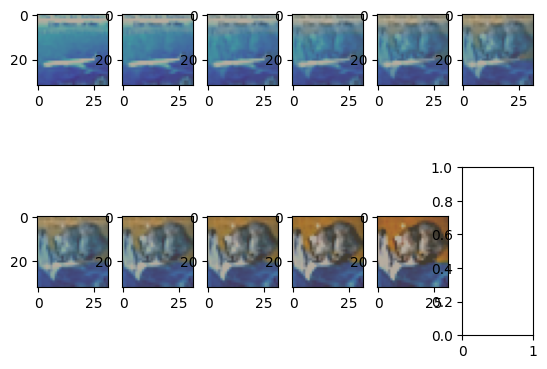

In [54]:
temp = linear_interpolation(z, 10, z_hat)
# temp.shape

fig, axes = plt.subplots(2, 6)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


for i in range(temp.size(0)):
    interp = AutoencoderExaminer.reconstruct_latent(ae, temp[i])
    
    ax = next(axes_flat)
    ax.imshow(convert_to_img(interp.squeeze(0)))
    


Latent Gradient

In [6]:
device = 'cuda:7'
valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked', train=False, transform=transform)

classifier = torch.load('/data8/donghun/cifar10/results/densenet/script_model.pt', map_location='cpu')
model = classifier.eval().to(device)

ae = torch.load('/data8/donghun/cifar10/results/ae/script_model.pt', map_location='cpu')
ae = ae.to(device)

img, lab = valid_dataset[0]

In [9]:
temp = []
for i in range(100):
    img, lab = valid_dataset[i]
    img = img.to(device)
    x_hat, loss_dict, info = AutoencoderExaminer.reconstruct_input(ae, img.unsqueeze(0))    
    z = info['bottleneck']

    j = 0
    sc = 100
    while sc > 0.01:
        j += 1
        grad = AutoencoderExaminer.get_classifier_latent_direction(ae, model, z, lab)
        z -= grad * 100
        x_hat = AutoencoderExaminer.reconstruct_latent(ae, z)
        logit = model(x_hat)
        score = nn.functional.softmax(logit, dim = -1)
        sc = score[:, lab]
        if j > 10: 
            print(i, sc)
            break
    # print(j)
    temp.append(j)

print(sum(temp))

# ascent
# 10 - 744
# 20 - 653    
# 30 - 609
# 40 - 537
# 50 - 530
# 100 - 418

# descent - 

/home/dhlee/anaconda3/envs/dh1/lib/python3.8/site-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %306 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)


52 tensor([0.1076], device='cuda:7', grad_fn=<SelectBackward0>)
201


In [ ]:
img = img.to(device)
# print(img.shape)
x_hat, loss_dict, info = AutoencoderExaminer.reconstruct_input(ae, img.unsqueeze(0))    
z = info['bottleneck']

for i in range(20):
    grad = AutoencoderExaminer.get_classifier_latent_direction(ae, model, z, lab)
    z += grad * 10
    x_hat = AutoencoderExaminer.reconstruct_latent(ae, z)
    logit = model(x_hat)
    score = nn.functional.softmax(logit, dim = -1)
    sc = score[:, lab]
    print(sc)


In [ ]:
def get_classifier_latent_direction(autoencoder, classifier, z, y):
    
    # clean the gradients 
    autoencoder.zero_grad()
    classifier.zero_grad()        
    
    z = torch.autograd.Variable(z, requires_grad=True).to(z.dtype)
    x_hat = autoencoder.decode(z)
    output = classifier(x_hat)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(z.size(0), output.size()[-1]).zero_().to(z.device).type(z.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)
    return z.grad.detach()

# --- Test Img -> Recon ---
x_hat, loss_dict, info = AutoencoderExaminer.reconstruct_input(model, input)    
AutoencoderExaminer.save_original_and_reconstruction(x_hat,
                                                     input,
                                                     CIFAR10_STATS['mean'],
                                                    CIFAR10_STATS['std'], 
                                                    f'results/{model.__class__.__name__}_recon.pdf' , figsize=(10, 2))

# --- Test Latent -> Recon ---
z = info['bottleneck']
grad = AutoencoderExaminer.get_classifier_latent_direction(model, classifier, z, y=0)
# for i in range(100):
z += grad  * 10
    
x_hat = AutoencoderExaminer.reconstruct_latent(model, z)
AutoencoderExaminer.save_reconstruction(x_hat, CIFAR10_STATS['mean'], CIFAR10_STATS['std'], f'results/{model.__class__.__name__}_recon.pdf', figsize=(10,2))

# --- Test (Random) Latent -> Recon ---
z = sample(model, num_samples=2)
grad = AutoencoderExaminer.get_classifier_latent_direction(model, classifier, z, y=0)
x_hat = AutoencoderExaminer.reconstruct_latent(model, z)
AutoencoderExaminer.save_reconstruction(x_hat, CIFAR10_STATS['mean'], CIFAR10_STATS['std'], f'results/{model.__class__.__name__}_recon.pdf', figsize=(3,2))
# ----------------


Image Gradient ascent - times

In [117]:
def get_gradient(model, x, y, device):
    temp = Variable(x, requires_grad=True).to(device)
    temp = temp.unsqueeze(0)
    temp.retain_grad()
    model.zero_grad()

    output = model(temp)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(temp.size(0), output.size()[-1]).zero_().to(device).type(temp.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = temp.grad
    return gradient, score[:, y]

def image_gradient_interpolation(model, x, y, M, device):
    model = model.to(device)
    x = x.to(device)
    
    interp = []
    interp.append(x)
    
    for i in range(M):    
        grad = get_gradient(model, x, y, device)
        x = x - grad.squeeze(0)        
        interp.append(x)
    interp = torch.stack(interp)
    return interp

In [122]:
temp = []
for i in range(100):
    img = valid_dataset[i][0].to(device)
    lab = valid_dataset[i][1]
    j = 0
    score = 100
    while score > 0.01:
        # print(j)
        j += 1
        grad, sc= get_gradient(model, img, lab, device)
        # print(sc)
        img_hat = img + grad.squeeze(0) * 5
        # print(img_hat.size())
        score = sc
        img = img_hat
        if j > 10: break
    print(j)
    temp.append(j)    
print(sum(temp))
    

11
8
11
3
11
11
3
11
11
11
11
11
2
4
11
2
4
11
4
11
2
3
11
11
2
11
11
11
11
11
11
2
2
2
4
11
2
1
11
11
11
11
2
3
11
11
11
2
11
11
11
3
2
11
11
3
2
2
1
2
11
1
11
11
11
11
11
11
11
11
11
11
3
4
2
11
3
11
11
11
3
3
11
3
11
2
11
11
9
3
11
11
8
3
3
11
11
2
11
3
754


In [129]:
a1 = torch.zeros(3, 32, 32)
a2 = torch.zeros(3, 32, 32)
a = [a1, a2]
b = torch.stack(a)
b.shape

torch.Size([2, 3, 32, 32])

Debug Latent Gradient

In [ ]:
attribution = torch.from_numpy(np.load('/home/dhlee/results/cifar10/not_compressed/latent_gradient_ascent_attribution.npy'))
# interp.shape # 10000, 11, 3, 32, 32
# attr.shape # 10000, 3, 32, 32
nw = []
for i in range(attribution.size(0)):
    temp = attribution[i]
    print(temp.shape)
    new = temp.mean(dim = 0)
    print(new.shape)
    nw.append(new)
    # break
    
g = torch.stack(nw)
g.shape

In [23]:
np.save('/home/dhlee/results/cifar10/latent_gradient_ascent_attribution.npy', g.numpy())

In [13]:
from ig_pkg.utils.attribution import integrated_gradient
input, label = valid_dataset[0]
attr1 = integrated_gradient(model, input.to(device), label, interp[0][-1].unsqueeze(0).to(device), interp[0].to(device), device) # 32, 32
attr1.shape

torch.Size([3, 32, 32])

In [15]:
print(torch.mean(attr))
print(torch.mean(attr1))

tensor(0.0019, device='cuda:2')
tensor(0.0019, device='cuda:2')


In [24]:
attribution = torch.from_numpy(np.load('/home/dhlee/results/cifar10/not_compressed/latent_gradient_attribution.npy'))
# interp.shape # 10000, 11, 3, 32, 32
# attr.shape # 10000, 3, 32, 32
nw = []
for i in range(attribution.size(0)):
    temp = attribution[i]
    # print(temp.shape)
    new = temp.mean(dim = 0)
    # print(new.shape)
    nw.append(new)
    # break
    
g = torch.stack(nw)
# g.shape

np.save('/home/dhlee/results/cifar10/latent_gradient_attribution.npy', g.numpy())

torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])
torch.Size

save json samples without gradient

In [25]:
import json

with open("/home/dhlee/code/ig_inversion/results/evaluation_samples_cifar10.json", "r") as st_json:
    avg = json.load(st_json)

avg.keys()


dict_keys(['aopc_expected_0.01', 'aopc_expected_0.05', 'aopc_expected_0.1', 'aopc_image_gradient_0.01', 'aopc_image_gradient_0.05', 'aopc_image_gradient_0.1', 'aopc_image_gradient_ascent_0.01', 'aopc_image_gradient_ascent_0.05', 'aopc_image_gradient_ascent_0.1', 'aopc_latent_gradient_ascent_0.01', 'aopc_latent_gradient_ascent_0.05', 'aopc_latent_linear_0.01', 'aopc_latent_linear_0.05', 'aopc_latent_linear_0.1', 'aopc_zero_0.01', 'aopc_zero_0.05', 'aopc_zero_0.1', 'lerf_expected_0.01', 'lerf_expected_0.05', 'lerf_expected_0.1', 'lerf_image_gradient_0.01', 'lerf_image_gradient_0.05', 'lerf_image_gradient_0.1', 'lerf_image_gradient_ascent_0.01', 'lerf_image_gradient_ascent_0.05', 'lerf_image_gradient_ascent_0.1', 'lerf_latent_gradient_ascent_0.01', 'lerf_latent_gradient_ascent_0.05', 'lerf_latent_linear_0.01', 'lerf_latent_linear_0.05', 'lerf_latent_linear_0.1', 'lerf_zero_0.01', 'lerf_zero_0.05', 'lerf_zero_0.1', 'lodds_expected_0.01', 'lodds_expected_0.05', 'lodds_expected_0.1', 'lodds_

In [29]:
tem = list(avg.keys())
for i in tem:
    if "gradient" in i:
        _ = avg.pop(i)
    elif "latent" in i:
        _ = avg.pop(i)
print(avg.keys())

dict_keys(['aopc_expected_0.01', 'aopc_expected_0.05', 'aopc_expected_0.1', 'aopc_zero_0.01', 'aopc_zero_0.05', 'aopc_zero_0.1', 'lerf_expected_0.01', 'lerf_expected_0.05', 'lerf_expected_0.1', 'lerf_zero_0.01', 'lerf_zero_0.05', 'lerf_zero_0.1', 'lodds_expected_0.01', 'lodds_expected_0.05', 'lodds_expected_0.1', 'lodds_zero_0.01', 'lodds_zero_0.05', 'lodds_zero_0.1', 'morf_expected_0.01', 'morf_expected_0.05', 'morf_expected_0.1', 'morf_zero_0.01', 'morf_zero_0.05', 'morf_zero_0.1'])


In [35]:
with open(os.path.join("/home/dhlee/code/ig_inversion/results/evaluation_samples_cifar10.json"), 'w') as f:
        json.dump(avg, f, indent=2, sort_keys=True)
        

In [30]:
with open("/home/dhlee/code/ig_inversion/results/evaluation_average_cifar10.json", "r") as st_json:
    all = json.load(st_json)
    


In [34]:
all.keys()

for i in range(len(list(avg.keys()))):
    print(list(avg.keys())[i], list(all.keys())[i])

aopc_expected_0.01 aopc_expected_0.01
aopc_expected_0.05 aopc_expected_0.05
aopc_expected_0.1 aopc_expected_0.1
aopc_zero_0.01 aopc_zero_0.01
aopc_zero_0.05 aopc_zero_0.05
aopc_zero_0.1 aopc_zero_0.1
lerf_expected_0.01 lerf_expected_0.01
lerf_expected_0.05 lerf_expected_0.05
lerf_expected_0.1 lerf_expected_0.1
lerf_zero_0.01 lerf_zero_0.01
lerf_zero_0.05 lerf_zero_0.05
lerf_zero_0.1 lerf_zero_0.1
lodds_expected_0.01 lodds_expected_0.01
lodds_expected_0.05 lodds_expected_0.05
lodds_expected_0.1 lodds_expected_0.1
lodds_zero_0.01 lodds_zero_0.01
lodds_zero_0.05 lodds_zero_0.05
lodds_zero_0.1 lodds_zero_0.1
morf_expected_0.01 morf_expected_0.01
morf_expected_0.05 morf_expected_0.05
morf_expected_0.1 morf_expected_0.1
morf_zero_0.01 morf_zero_0.01
morf_zero_0.05 morf_zero_0.05
morf_zero_0.1 morf_zero_0.1


In [ ]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

# {'gaussian',
#  'gaussian_blur',
#  'max',
#  'maximumdistance',
#  'min',
#  'one',
#  'scalar',
#  'uniform',
#  'zero'}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
Kendal = []
for name in names:
    print(name)
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    Kendal.append(kendal_correlation(eval_mode, ferrot_tensor, baseline, attr.detach().cpu().numpy(), device))

#     print(name)
    for i in range(19):
#         k = i * 5 + 5        
        k = i + 1
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
        
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()